Initial Dataset Loading

In [ ]:
#pip install resampy

In [ ]:
#pip install pysoundfile

In [32]:
import librosa
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Define the path to the main dataset directory containing 'fold1' to 'fold10'
dataset_dir = r'C:\Users\Paul\Downloads\Masters\MSc_DA_CA3\UrbanSound8K\UrbanSound8K\audio'

# Create extract_features() function
# This function will extract features from a single sound file, such as the MFCCs.
# It takes 1 parameter:
#     file_name: the path to the sound file
# It returns 1 value:
#     features: a numpy array of sound features

def extract_features(file_path):
    # Load the audio file
    audio, _ = librosa.load(file_path, res_type='kaiser_fast')

    # Extract features (e.g., Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)

    # Flatten the feature matrix
    mfccs = np.mean(mfccs.T, axis=0)

    return mfccs



In [3]:
# Process all audio files in the 'foldX' directories
#THIS CAN TAKE UP TO 10 MINUTES TO RUN

# Create an empty list of features
feature_list = []

# Get the list of folders in the main dataset directory
for folder in os.listdir(dataset_dir):
    if folder.startswith('fold'):
        folder_path = os.path.join(dataset_dir, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                features = extract_features(file_path)
                feature_list.append(features)

c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


EDA

In [4]:
# Examine the size of the feature list
print('Number of feature vectors:', len(feature_list))

Number of feature vectors: 8732


In [5]:
# Are the feature vectors all the same size?
print('Feature vector length:', len(feature_list[0]))

Feature vector length: 13


In [9]:
# Load the CSV file into a DataFrame
metadata = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8k.csv')


In [10]:
def extract_features(file_path, metadata):
    # Extract the class label based on the file name
    file_name = os.path.basename(file_path)
    class_label = metadata[metadata['slice_file_name'] == file_name]['class'].values[0]

    # Load the audio file
    audio, _ = librosa.load(file_path, res_type='kaiser_fast')

    # Extract features (e.g., Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)

    # Flatten the feature matrix
    mfccs = np.mean(mfccs.T, axis=0)

    return mfccs, class_label


In [11]:
# Create an empty list of features and labels
feature_list = []
label_list = []

# Get the list of folders in the main dataset directory
for folder in os.listdir(dataset_dir):
    if folder.startswith('fold'):
        folder_path = os.path.join(dataset_dir, folder)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                features, class_label = extract_features(file_path, metadata)
                feature_list.append(features)
                label_list.append(class_label)


c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\Users\Paul\anaconda3\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [19]:
# Create a list of meaningful column names based on MFCC descriptions
mfcc_column_names = [
    'mfcc_energy',
    'mfcc_spectral_low1',
    'mfcc_spectral_mid1',
    'mfcc_spectral_mid2',
    'mfcc_spectral_mid3',
    'mfcc_spectral_high1',
    'mfcc_spectral_high2',
    'mfcc_spectral_high3',
    'mfcc_spectral_high4',
    'mfcc_spectral_high5',
    'mfcc_detail1',
    'mfcc_detail2',
    'mfcc_detail3'
]

# Assign the created column names to the features DataFrame
features.columns = mfcc_column_names

                fsID        start          end     salience         fold  \
count    8732.000000  8732.000000  8732.000000  8732.000000  8732.000000   
mean   116033.493816    38.645409    42.253312     1.347000     5.385937   
std     57991.017218    74.292126    74.369669     0.476043     2.846820   
min       344.000000     0.000000     0.105962     1.000000     1.000000   
25%     69942.250000     3.000000     6.839398     1.000000     3.000000   
50%    118279.000000    10.376492    14.000000     1.000000     5.000000   
75%    166942.000000    35.131372    38.866979     2.000000     8.000000   
max    209992.000000   600.125356   604.125356     2.000000    10.000000   

           classID  
count  8732.000000  
mean      4.592877  
std       2.894544  
min       0.000000  
25%       2.000000  
50%       4.000000  
75%       7.000000  
max       9.000000  
slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0


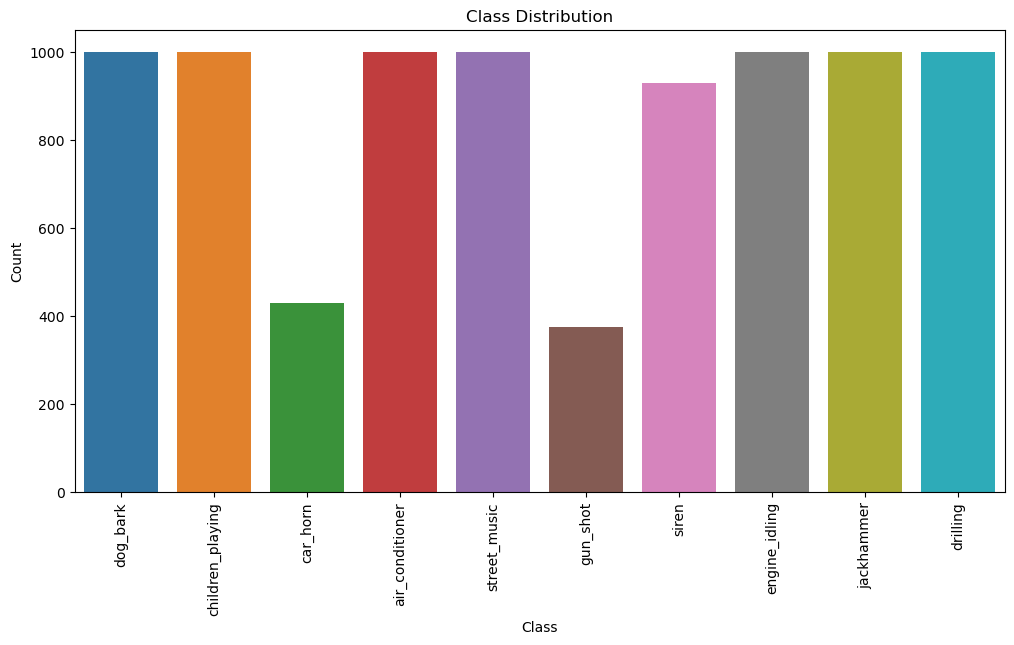

       mfcc_energy  mfcc_spectral_low1  mfcc_spectral_mid1  \
count  8732.000000         8732.000000         8732.000000   
mean   -230.184631          114.321854          -27.656820   
std     129.707123           48.001690           31.378609   
min    -766.317749          -64.599388         -165.692215   
25%    -313.787605           86.691669          -44.714517   
50%    -217.100456          120.122486          -24.517739   
75%    -131.428020          147.059368           -8.226402   
max     129.532166          276.579529           83.811600   

       mfcc_spectral_mid2  mfcc_spectral_mid3  mfcc_spectral_high1  \
count         8732.000000         8732.000000          8732.000000   
mean            20.384014          -12.987039            14.454811   
std             21.766222           15.723857            14.681323   
min            -79.691612          -99.794167           -58.930050   
25%              9.304368          -23.082563             6.195792   
50%             23.09

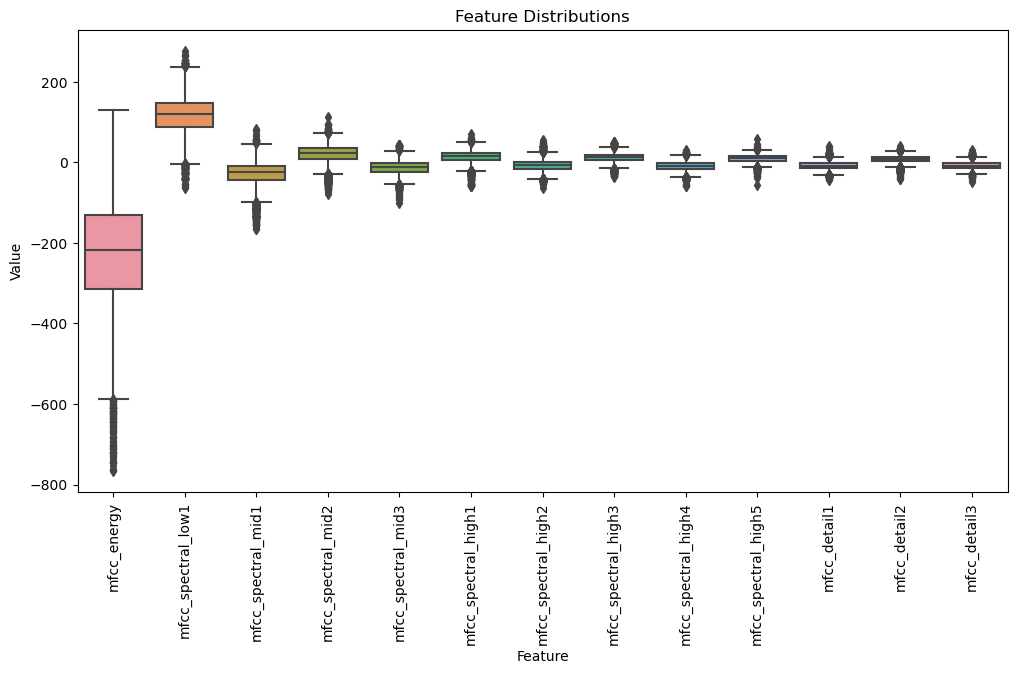

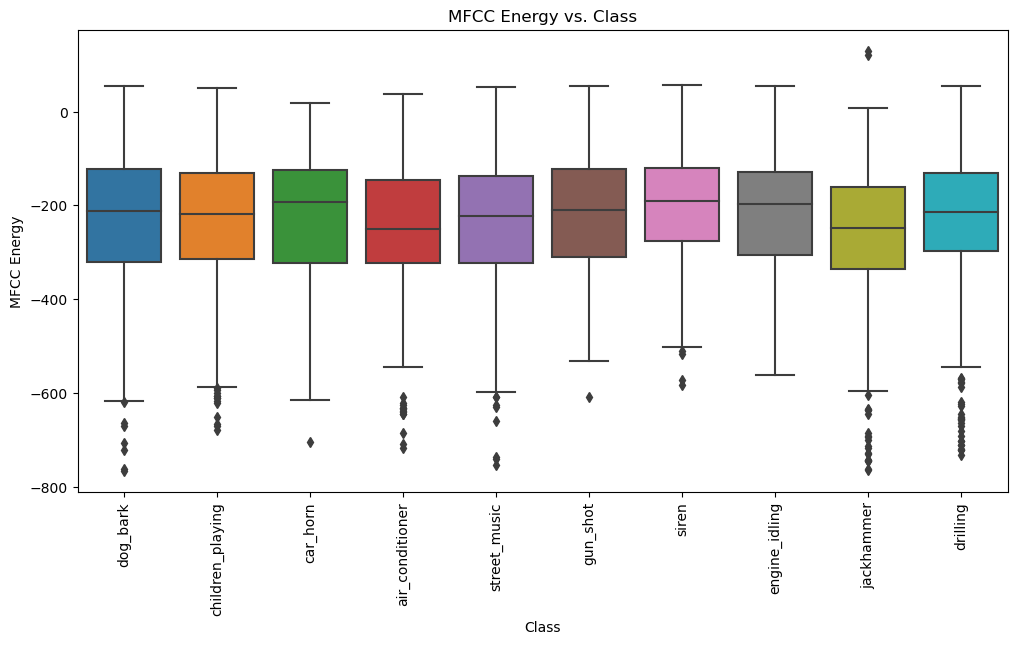

Test for class dog_bark: t-statistic=0.36192885328845226, p-value=0.7174139576060821
Test for class children_playing: t-statistic=0.3428966815776828, p-value=0.7316844442872972
Test for class car_horn: t-statistic=1.3675435720991733, p-value=0.17149019422392164
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13
Test for class drilling: t-statistic=0.3984356822897764, p-value=0.6903188038090458


In [21]:
# Load the CSV file with metadata
metadata = pd.read_csv('UrbanSound8K/UrbanSound8K/metadata/UrbanSound8k.csv')

# Display basic statistics about the dataset
print(metadata.describe())

# Check for missing values
print(metadata.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=metadata, x='class')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Explore feature statistics
features = pd.DataFrame(feature_list)

# Assign the MFCC column names
mfcc_column_names = [
    'mfcc_energy',
    'mfcc_spectral_low1',
    'mfcc_spectral_mid1',
    'mfcc_spectral_mid2',
    'mfcc_spectral_mid3',
    'mfcc_spectral_high1',
    'mfcc_spectral_high2',
    'mfcc_spectral_high3',
    'mfcc_spectral_high4',
    'mfcc_spectral_high5',
    'mfcc_detail1',
    'mfcc_detail2',
    'mfcc_detail3'
]

features.columns = mfcc_column_names

# Display basic statistics about the features
print(features.describe())

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=features)
plt.title('Feature Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

# Explore relationships between features and class labels
merged_data = pd.concat([features, metadata['class']], axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='class', y='mfcc_energy')  # Replace 'feature_column_name' with 'mfcc_energy' or any other MFCC column you want to visualize
plt.title('MFCC Energy vs. Class')  # Adjust the title accordingly
plt.xlabel('Class')
plt.ylabel('MFCC Energy')
plt.xticks(rotation=90)
plt.show()

# Perform statistical tests (e.g., t-tests or ANOVA) to assess feature significance
from scipy.stats import ttest_ind

class_labels = metadata['class'].unique()
for label in class_labels:
    group1 = features[metadata['class'] == label]['mfcc_energy']  # Replace 'feature_column_name' with 'mfcc_energy' or any other MFCC column
    group2 = features[metadata['class'] != label]['mfcc_energy']  # Replace 'feature_column_name' with 'mfcc_energy' or any other MFCC column
    t_stat, p_value = ttest_ind(group1, group2)
    print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}')


In [31]:
alpha = 0.05

class_labels = metadata['class'].unique()

for mfcc_column_name in mfcc_column_names:
    print(f"Testing significance for feature column: {mfcc_column_name}")
    for label in class_labels:
        group1 = features[metadata['class'] == label][mfcc_column_name]
        group2 = features[metadata['class'] != label][mfcc_column_name]
        t_stat, p_value = ttest_ind(group1, group2)
        if p_value < alpha:
            print(f'Test for class {label}: t-statistic={t_stat}, p-value={p_value}') # Reject null hypothesis
    print("\n")

Testing significance for feature column: mfcc_energy
Test for class air_conditioner: t-statistic=-4.046567321229036, p-value=5.2422395017633404e-05
Test for class street_music: t-statistic=-2.674581050148306, p-value=0.007496209967690917
Test for class gun_shot: t-statistic=2.101028221427894, p-value=0.03566708602241529
Test for class siren: t-statistic=7.137707769257521, p-value=1.0248855524025598e-12
Test for class engine_idling: t-statistic=3.756710587912719, p-value=0.00017328188220103283
Test for class jackhammer: t-statistic=-7.317773855783848, p-value=2.7443525119233534e-13


Testing significance for feature column: mfcc_spectral_low1
Test for class dog_bark: t-statistic=-2.5122938309291096, p-value=0.012012803433766601
Test for class car_horn: t-statistic=-2.831892669453514, p-value=0.004637928784580187
Test for class air_conditioner: t-statistic=2.6064278970888974, p-value=0.00916475428894602
Test for class street_music: t-statistic=-2.252410770307752, p-value=0.02432106231411

Sound Classfication Model

Epoch 1/50
175/175 - 1s - loss: 10.4946 - accuracy: 0.1154 - val_loss: 2.2688 - val_accuracy: 0.1267 - 1s/epoch - 7ms/step
Epoch 2/50
175/175 - 0s - loss: 2.4088 - accuracy: 0.1378 - val_loss: 2.2444 - val_accuracy: 0.1446 - 453ms/epoch - 3ms/step
Epoch 3/50
175/175 - 1s - loss: 2.2820 - accuracy: 0.1582 - val_loss: 2.1879 - val_accuracy: 0.1918 - 537ms/epoch - 3ms/step
Epoch 4/50
175/175 - 1s - loss: 2.2214 - accuracy: 0.1781 - val_loss: 2.1099 - val_accuracy: 0.2241 - 692ms/epoch - 4ms/step
Epoch 5/50
175/175 - 1s - loss: 2.1747 - accuracy: 0.1979 - val_loss: 2.0749 - val_accuracy: 0.2326 - 671ms/epoch - 4ms/step
Epoch 6/50
175/175 - 1s - loss: 2.1380 - accuracy: 0.2044 - val_loss: 2.0155 - val_accuracy: 0.2419 - 793ms/epoch - 5ms/step
Epoch 7/50
175/175 - 1s - loss: 2.1149 - accuracy: 0.2119 - val_loss: 2.0056 - val_accuracy: 0.2355 - 578ms/epoch - 3ms/step
Epoch 8/50
175/175 - 0s - loss: 2.1083 - accuracy: 0.2153 - val_loss: 1.9928 - val_accuracy: 0.2634 - 446ms/epoch - 3ms/step
Ep

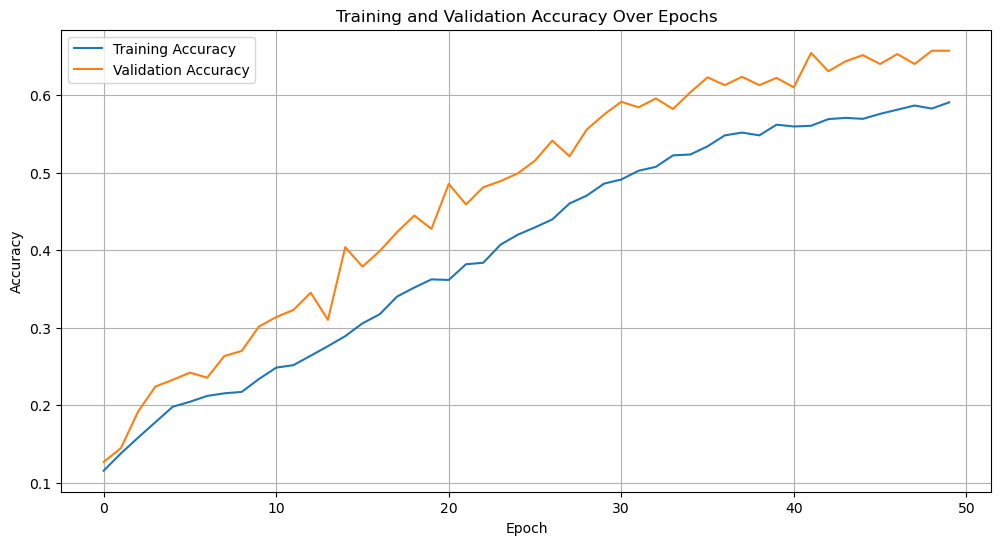

In [33]:
# Convert lists to NumPy arrays
X = np.array(feature_list)
y = np.array(label_list)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the deep learning model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Decode class labels
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Create a confusion matrix and classification report
confusion = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()
plt.show()